In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.backends.backend_pdf import PdfPages
import time
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp

from mpl_toolkits import mplot3d

%matplotlib notebook

# Define the variables
t, r, theta, phi, = sp.symbols('t r theta phi')
dt, dr, dtheta, dphi, M = sp.symbols('dt dr dtheta dphi M')
# Equations of motion in sympy, most other in numpy

In [3]:
# Metric Elements (Schwarzschild)
gtt = -(1 - (2*M/r))
grr = -1/gtt
gthetatheta = r**2
gphiphi = (r**2)*(sp.sin(theta)**2)

g = (sp.Matrix([[gtt, 0, 0, 0], [0, grr, 0, 0], [0, 0, gthetatheta, 0], [0, 0, 0, gphiphi]]))
g

Matrix([
[2*M/r - 1,              0,    0,                  0],
[        0, -1/(2*M/r - 1),    0,                  0],
[        0,              0, r**2,                  0],
[        0,              0,    0, r**2*sin(theta)**2]])

In [4]:
ginv = g.inv()
ginv

Matrix([
[1/(2*M/r - 1),          0,       0,                      0],
[            0, -2*M/r + 1,       0,                      0],
[            0,          0, r**(-2),                      0],
[            0,          0,       0, 1/(r**2*sin(theta)**2)]])

In [5]:
pt, pr, ptheta, pphi, m = sp.symbols('pt pr ptheta pphi m')

# Compute the expression for H
# H = (1/2m)g^(mu,nu)*p_mu*p_nu
Hamil = (1/(2*m)) * (
    ginv[0, 0]* (pt**2) + 
    ginv[1, 1]* (pr**2) + 
    ginv[2, 2]* (ptheta**2) + 
    ginv[3, 3]* (pphi**2)
)

print(sp.simplify(Hamil))
Hamil

(pphi**2/(r**2*sin(theta)**2) - pr**2*(2*M/r - 1) + pt**2/(2*M/r - 1) + ptheta**2/r**2)/(2*m)


(pphi**2/(r**2*sin(theta)**2) + pr**2*(-2*M/r + 1) + pt**2/(2*M/r - 1) + ptheta**2/r**2)/(2*m)

In [6]:
from sympy import diff

# Partial derivatives with respect to pt, pr, p_theta, p_phi,
partial_t = diff(Hamil, t)
partial_pt = diff(Hamil, pt)
partial_r = diff(Hamil, r)
partial_pr = diff(Hamil, pr)
partial_theta = diff(Hamil, theta)
partial_p_theta = diff(Hamil, ptheta)
partial_phi = diff(Hamil, phi)
partial_p_phi = diff(Hamil, pphi)

# Partial H partial t is = dpt/dtau, negative inverses (normal hamiltonian mechanics)
print("dpt/dtau:", -partial_t)
print(" ")
print("dt/dtau:", partial_pt)
print(" ")
print("dpr/dtau:", -partial_r)
print(" ")
print("dr/dtau:", partial_pr)
print(" ")
print("dptheta/dtau:", -partial_theta)
print(" ")
print("dtheta/dtau:", partial_p_theta)
print(" ")
print("dpphi/dtau:", -partial_phi)
print(" ")
print("dphi/dtau:", partial_p_phi)

dpt/dtau: 0
 
dt/dtau: pt/(m*(2*M/r - 1))
 
dpr/dtau: -(2*M*pr**2/r**2 + 2*M*pt**2/(r**2*(2*M/r - 1)**2) - 2*pphi**2/(r**3*sin(theta)**2) - 2*ptheta**2/r**3)/(2*m)
 
dr/dtau: pr*(-2*M/r + 1)/m
 
dptheta/dtau: pphi**2*cos(theta)/(m*r**2*sin(theta)**3)
 
dtheta/dtau: ptheta/(m*r**2)
 
dpphi/dtau: 0
 
dphi/dtau: pphi/(m*r**2*sin(theta)**2)


In [7]:
# Set up the parameters
M = 10000 # Mass of the central black hole 
m = 1 # Mass of the planet 
G = 1 # Gravitational Constant 
c = 1 # Speed of light

#R = 100000000 #Circular orbit
#L = 1000000 #Circular orbit

R = 900000 #Whirl-zoom
L = 39000

#R = 500000 #Whirl-zoom
#L = 20000
#R = 300000

pphi = L

In [8]:
def system_of_odes(t,y):
    r, pr, time, pt, theta, ptheta, phi = y     
    
    dRdt = pr*(-2*M/r + 1)/m
    
    dpRdt = -(2*M*pr**2/r**2 + 2*M*pt**2/(r**2*(2*M/r - 1)**2) - 2*pphi**2/(r**3*sp.sin(theta)**2) - 2*ptheta**2/r**3)/(2*m)

    dtimedt = pt/(m*(2*M/r - 1))
    
    dptdt = 0

    dthetadt = ptheta/(m*r**2)
    
    dpthetadt = pphi**2*sp.cos(theta)/(m*r**2*sp.sin(theta)**3)
        
    dphidt = pphi/(m*r**2*sp.sin(theta)**2)

    return [dRdt,dpRdt,dtimedt,dptdt, dthetadt, dpthetadt, dphidt]

In [9]:
def Constraint(r,pr,time,pt,theta,ptheta,phi):

    H = (pphi**2/(r**2*sp.sin(theta)**2) - pr**2*(2*M/r - 1) + pt**2/(2*M/r - 1) + ptheta**2/r**2)/(2*m)

    return H

def secant(f,x0,x1):
    x = np.array([x0,x1])

    for i in range(400):
        if f(x1) - f(x0) == 0:
            #print("Division by zero")
            return x[-1]

        xn_1 = x1 - f(x1) * ((x1 - x0)/(f(x1) - f(x0)))
        x = np.append(x, xn_1)
        x0 = x1
        x1 = xn_1
    return x[-1]

In [10]:
theta_initial = (np.pi)/2
ptheta_initial = 0.0

pt_initial = secant(lambda pt: Constraint(R,0,0,pt,theta_initial,ptheta_initial,0) + (m/2),0,1)

r0 = np.array([R,0,0,pt_initial,theta_initial,ptheta_initial,0]) #R(0),pR(0),t(0),pt(0),theta(0),ptheta(0),phi(0)

initial_conditions = r0

print(pt_initial) 

ti_initial = 0
tf = (3e8)/6
t_span = (ti_initial,tf)

start = time.time()
t_eval = np.linspace(ti_initial,tf,100000)

sol = solve_ivp(system_of_odes, t_span, initial_conditions, method='DOP853', t_eval = t_eval, rtol = 1e-8, atol = 1e-10)
    
end = time.time()
print(end - start)

print(sol)

0.989754427704415
32.77369022369385
  message: 'Required step size is less than spacing between numbers.'
     nfev: 3413
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.000000e+00, 5.000050e+02, 1.000010e+03, ..., 1.099811e+07,
       1.099861e+07, 1.099911e+07])
 t_events: None
        y: array([[ 9.00000000e+05,  8.99999999e+05,  8.99999995e+05, ...,
         2.13328061e+04,  2.09008972e+04,  2.04450952e+04],
       [ 0.00000000e+00, -5.28182892e-06, -1.05636579e-05, ...,
        -1.34709366e+01, -2.05741133e+01, -4.30564830e+01],
       [ 0.00000000e+00, -5.06129485e+02, -1.01225897e+03, ...,
        -1.16695861e+07, -1.16790408e+07, -1.16947975e+07],
       ...,
       [ 1.57079633e+00,  1.57079633e+00,  1.57079633e+00, ...,
         1.57079633e+00,  1.57079633e+00,  1.57079633e+00],
       [ 0.00000000e+00,  5.74909386e-17,  1.14981878e-16, ...,
        -1.23685709e-12, -1.13243459e-12, -1.02348091e-12],
       [ 0.00000000e+00,  2.407

<IPython.core.display.Javascript object>


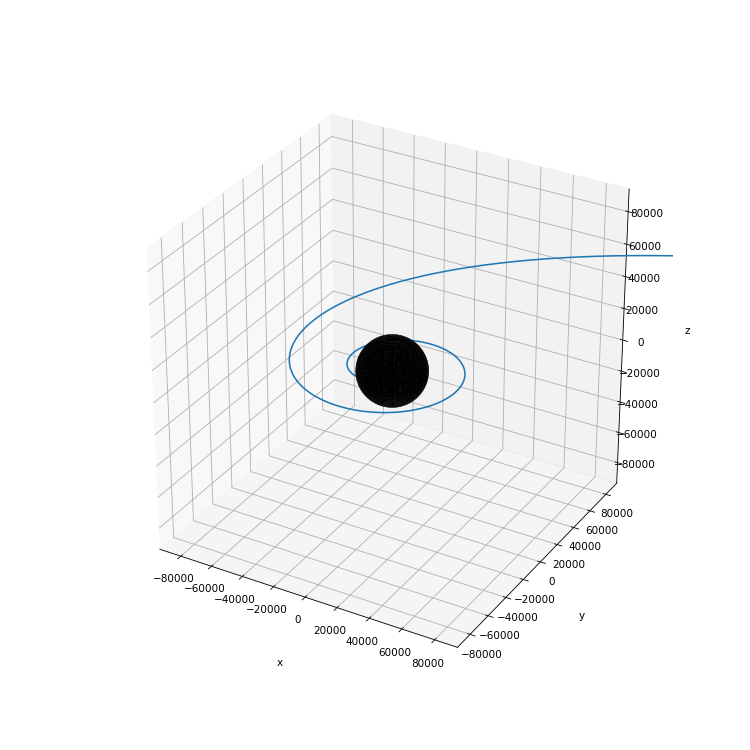

In [12]:
Theta = sol.y[4,:]
Phi = sol.y[6,:]
X = sol.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol.y[0,:] * np.round(np.cos(Theta),14)

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()

ax1.plot3D(X,Y,Z)

#Plotting meant for Kerr
shwr_R = 2*G*M
J=0

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_shwr = shwr_R * np.outer(np.cos(u), np.sin(v))
y_shwr = shwr_R * np.outer(np.sin(u), np.sin(v))
z_shwr = shwr_R * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

#'b' is blue, 'k' is black, 'r' is red
ax1.plot_surface(x_shwr,y_shwr,z_shwr, color = 'k')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.0)

zoom = 10

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()

In [26]:
r_stop = 6*G*M

def event_function(t,r):
    R = r[0]
    return R-r_stop

event_function.terminal = True

sol2 = solve_ivp(system_of_odes, t_span, initial_conditions, method='DOP853', t_eval = t_eval, events=event_function, dense_output=True, rtol = 1e-8, atol = 1e-10)

print(sol2.t_events)
print(sol2.y_events)

[array([10708915.8995391])]
[array([[ 6.00000000e+04, -2.65294386e-01, -1.10705821e+07,
         9.89754428e-01,  1.57079633e+00,  7.93108785e-12,
         3.30925894e+00]])]
[900000 0 0 0.989754427704415 1.5707963267948966 0.0 0]


In [49]:
sol2y = sol2.y_events
r01 = np.array([sol2y]) #R(0),pR(0),t(0),pt(0),theta(0),ptheta(0),phi(0)
print(sol2y)
print(sol2y[0][0])
#print(r01)
#print(initial_conditions)

ti_2 = sol2.t_events[0][0]
tf_2 = (3e8)/6
t_span2 = (ti_2, tf_2)
t_eval2 = np.linspace(ti_2,tf_2,100000)

sol_part1 = solve_ivp(system_of_odes, t_span2, sol2y[0][0], method='DOP853', t_eval = t_eval2, dense_output=True, rtol = 1e-8, atol = 1e-10)

print(sol_part1)

[array([[ 6.00000000e+04, -2.65294386e-01, -1.10705821e+07,
         9.89754428e-01,  1.57079633e+00,  7.93108785e-12,
         3.30925894e+00]])]
[ 6.00000000e+04 -2.65294386e-01 -1.10705821e+07  9.89754428e-01
  1.57079633e+00  7.93108785e-12  3.30925894e+00]
  message: 'Required step size is less than spacing between numbers.'
     nfev: 3227
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000014A1FE3E9A0>
   status: -1
  success: False
        t: array([10708915.8995391 , 10709308.81430926, 10709701.72907941,
       10710094.64384956, 10710487.55861971, 10710880.47338987,
       10711273.38816002, 10711666.30293017, 10712059.21770032,
       10712452.13247047, 10712845.04724063, 10713237.96201078,
       10713630.87678093, 10714023.79155108, 10714416.70632124,
       10714809.62109139, 10715202.53586154, 10715595.45063169,
       10715988.36540185, 10716381.280172  , 10716774.19494215,
       10717167.1097123 , 10717560.02448246, 10717952.

<IPython.core.display.Javascript object>


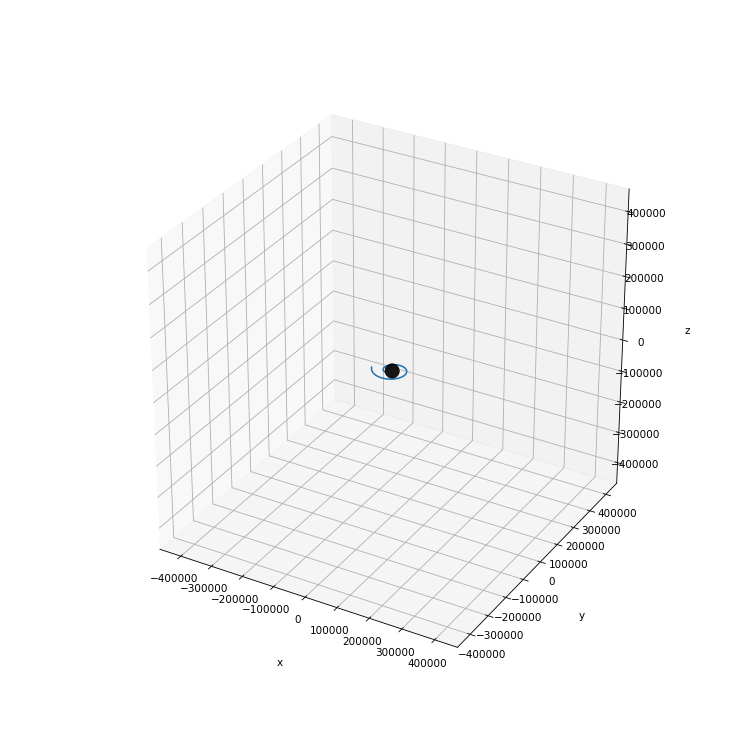

In [50]:
Theta = sol2.y[4,:]
Phi = sol2.y[6,:]
X = sol2.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol2.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol2.y[0,:] * np.round(np.cos(Theta),14)

#Theta = sol_part1.y[4,:]
#Phi = sol_part1.y[6,:]
#X = sol_part1.y[0,:] * np.sin(Theta) * np.cos(Phi)
#Y = sol_part1.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol_part1.y[0,:] * np.round(np.cos(Theta),14)

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()

ax1.plot3D(X,Y,Z)

#Plotting meant for Kerr
shwr_R = 2*G*M
J=0

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_shwr = shwr_R * np.outer(np.cos(u), np.sin(v))
y_shwr = shwr_R * np.outer(np.sin(u), np.sin(v))
z_shwr = shwr_R * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

#'b' is blue, 'k' is black, 'r' is red
ax1.plot_surface(x_shwr,y_shwr,z_shwr, color = 'k')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.0)

zoom = 2

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()